# The Transformer Decoder: Ungraded Lab Notebook

In this notebook you'll explore the transformer decoder and how to implement it with trax. 

## Background

In the last lecture notebook, you saw how to translate the mathematics of attention into NumPy code. Here, you'll see how multi-head causal attention fits into a GPT-2 transformer decoder, and how to build one with trax layers. In the assignment notebook, you'll implement causal attention from scratch, but here, you'll exploit the handy-dandy `tl.CausalAttention()` layer.

The schematic depiction below illustrates the components and flow of a transformer decoder. Note that while the algorithm diagram flows from the bottom to the top, the overview and subsequent Trax layer codes are top-down.

< src="images/C4_W2_L6_transformer-decoder_S01_transformer-decoder.png" width="1000"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>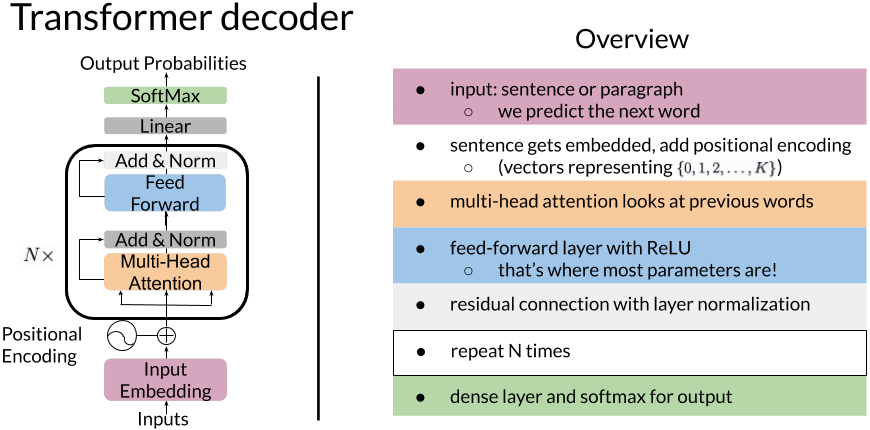</body></html>

## Imports

In [1]:
import sys
import os

import time
import numpy as np
import gin

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

## Sentence gets embedded, add positional encoding
Embed the words, then create vectors representing each word's position in each sentence $\in \{ 0, 1, 2, \ldots , K\}$ = `range(max_len)`, where `max_len` = $K+1$)

In [2]:
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
    """Returns a list of layers that: 
    1. takes a block of text as input, 
    2. embeds the words in that text, and 
    3. adds positional encoding, 
       i.e. associates a number in range(max_len) with 
       each word in each sentence of embedded input text 
    
    The input is a list of tokenized blocks of text
    
    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train' or 'eval'.
    """
    # Embedding inputs and positional encoder
    return [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),  
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode), 
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)] 

## Multi-head causal attention

The layers and array dimensions involved in multi-head causal attention (which looks at previous words in the input text) are summarized in the figure below: 

< src="images/C4_W2_L5_multi-head-attention_S05_multi-head-attention-concatenation_stripped.png" width="1000"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>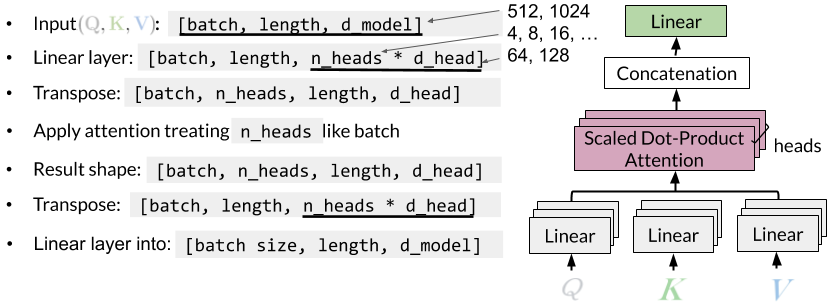</body></html>
`tl.CausalAttention()` does all of this for you! You might be wondering, though, whether you need to pass in your input text 3 times, since for causal attention, the queries Q, keys K, and values V all come from the same source. Fortunately, `tl.CausalAttention()` handles this as well by making use of the [`tl.Branch()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#module-trax.layers.combinators) combinator layer. In general, each branch within a `tl.Branch()` layer performs parallel operations on copies of the layer's inputs. For causal attention, each branch (representing Q, K, and V) applies a linear transformation (i.e. a dense layer without a subsequent activation) to its copy of the input, then splits that result into heads. You can see the syntax for this in the screenshot from the `trax.layers.attention.py` [source code](https://github.com/google/trax/blob/master/trax/layers/attention.py) below: 

< src="images/use-of-tl-Branch-in-tl-CausalAttention.png" width="500"/>
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>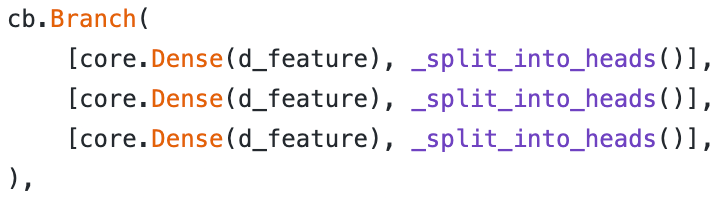</body></html>

## Feed-forward layer 
* Typically ends with a ReLU activation, but we'll leave open the possibility of a different activation
* Most of the parameters are here

In [3]:
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
    """Returns a list of layers that implements a feed-forward block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    # Create feed-forward block (list) with two dense layers with dropout and input normalized
    return [ 
        # Normalize layer inputs
        tl.LayerNorm(), 
        # Add first feed forward (dense) layer (don't forget to set the correct value for n_units)
        tl.Dense(d_ff), 
        # Add activation function passed in as a parameter (you need to call it!)
        ff_activation(),  # Generally ReLU
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode), 
        # Add second feed forward layer (don't forget to set the correct value for n_units)
        tl.Dense(d_model), 
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode) 
    ]

## Decoder block
Here, we return a list containing two residual blocks. The first wraps around the causal attention layer, whose inputs are normalized and to which we apply dropout regulation. The second wraps around the feed-forward layer. You may notice that the second call to `tl.Residual()` doesn't call a normalization layer before calling the feed-forward layer. This is because the normalization layer is included in the feed-forward layer.

In [4]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
        
    # Add list of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(), 
          # Add causal attention 
          tl.CausalAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode) 
        ),
      tl.Residual(
          # Add feed-forward block
          # We don't need to normalize the layer inputs here. The feed-forward block takes care of that for us.
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
        ),
      ]

## The transformer decoder: putting it all together
## A.k.a. repeat N times, dense layer and softmax for output

In [5]:
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    # Create stack (list) of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)] 

    # Create the complete model as written in the figure
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), 
        # Add embedding inputs and positional encoder
        PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
        # Add decoder blocks
        decoder_blocks, 
        # Normalize layer
        tl.LayerNorm(), 

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size), 
        # Get probabilities with Logsoftmax
        tl.LogSoftmax() 
    )

## Concluding remarks

In this week's assignment, you'll see how to train a transformer decoder on the [cnn_dailymail](https://www.tensorflow.org/datasets/catalog/cnn_dailymail) dataset, available from TensorFlow Datasets (part of TensorFlow Data Services). Because training such a model from scratch is time-intensive, you'll use a pre-trained model to summarize documents later in the assignment. Due to time and storage concerns, we will also not train the decoder on a different summarization dataset in this lab. If you have the time and space, we encourage you to explore the other [summarization](https://www.tensorflow.org/datasets/catalog/overview#summarization) datasets at TensorFlow Datasets. Which of them might suit your purposes better than the `cnn_dailymail` dataset? Where else can you find datasets for text summarization models?